#### Business problem

**Background:**

We are one of the fastest growing startups in the logistics and delivery domain. We work with several partners and make on-demand delivery to our customers. During the COVID-19 pandemic, we are facing several different challenges and everyday we are trying to address these challenges.

We thrive on making our customers happy. As a growing startup, with a global expansion strategy we know that we need to make our customers happy and the only way to do that is to measure how happy each customer is. If we can predict what makes our customers happy or unhappy, we can then take necessary actions.

Getting feedback from customers is not easy either, but we do our best to get constant feedback from our customers. This is a crucial function to improve our operations across all levels.

We recently did a survey to a select customer cohort. You are presented with a subset of this data. We will be using the remaining data as a private test set.

**Data Description:**

**Y** = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers

**X1** = my order was delivered on time

**X2** = contents of my order was as I expected

**X3** = I ordered everything I wanted to order

**X4** = I paid a good price for my order

**X5** = I am satisfied with my courier

**X6** = the app makes ordering easy for me

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

Goal(s):

***Predict if a customer is happy or not based on the answers they give to questions asked.***

Success Metrics:

Reach 73% accuracy score or above.


In [1]:
pip install xgboost

In [2]:
# Import libraries and models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import precision_score, classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import warnings

warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv('C:/Users/Tooman/Desktop/ACME-HappinessSurvey2020.csv')

## Data Exploration

In [3]:
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [4]:
#column names
X1 = "on_time"
X2 = "contents"
X3 = "complete_order"
X4 = "good_price"
X5 = "satisfied"
X6 = "app_ease"
Y = "customer_sentiment"

In [5]:
#rename the columns

df.columns = ['customer_sentiment', 'on_time', 'contents', 'complete_order', 'good_price', 'satisfied', 'app_ease']

In [6]:
df.head()

,customer_sentiment,on_time,contents,complete_order,good_price,satisfied,app_ease
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [7]:
print(df.shape)
print(df.size)

(126, 7)
882


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_sentiment,126.0,0.547619,0.499714,0.0,0.0,1.0,1.0,1.0
on_time,126.0,4.333333,0.800000,1.0,4.0,5.0,5.0,5.0
contents,126.0,2.531746,1.114892,1.0,2.0,3.0,3.0,5.0
complete_order,126.0,3.309524,1.023440,1.0,3.0,3.0,4.0,5.0
good_price,126.0,3.746032,0.875776,1.0,3.0,4.0,4.0,5.0
satisfied,126.0,3.650794,1.147641,1.0,3.0,4.0,4.0,5.0
app_ease,126.0,4.253968,0.809311,1.0,4.0,4.0,5.0,5.0


**Customer_sentiment:** Currently at an average of .54. This could be better and thus validates the necessity of a survey to discover what customers value in order to be happy

**On Time:** Average is at 4.33 out of 5 which is great. Most customers are receiving their packages on time and rate this highly.

**Contents as Expected:** Average of 2.53 out of 5. This is not great and deserves further inspection.

**Ordered Everything (Complete_order):** Average of 3.3 out of 5. Not bad, however not perfect either.

**Good Price:** Average of 3.74 out of 5. Again not bad, and customers seem to on average believe they are getting a good value.

**Satisied with Courier:** Decent average of 3.65 out of 5. Not bad.

**App Easy to Use:** Great Score of 4.25 out of 5. Customers seem to believe that the app is easy to use.

In [9]:
# checks for missing values in the dataset
df.isnull().sum()

customer_sentiment    0
on_time               0
contents              0
complete_order        0
good_price            0
satisfied             0
app_ease              0
dtype: int64

In [10]:
#check the unique values for all the features

In [11]:
print(df['on_time'].unique()) #the unique values for the columns
print(df['contents'].unique()) #the unique values for the columns
print(df['complete_order'].unique()) #the unique values for the columns
print(df['good_price'].unique()) #the unique values for the columns
print(df['satisfied'].unique()) #the unique values for the columns
print(df['app_ease'].unique()) #the unique values for the columns

[3 5 4 1]
[3 2 4 5 1]
[3 2 4 5 1]
[4 5 3 2 1]
[2 4 3 5 1]
[4 3 5 2 1]


In [12]:
df.corr()  #checks for the correlation of the variables against each other

,customer_sentiment,on_time,contents,complete_order,good_price,satisfied,app_ease
customer_sentiment,1.000000,0.280160,-0.024274,0.150838,0.064415,0.224522,0.167669
on_time,0.280160,1.000000,0.059797,0.283358,0.087541,0.432772,0.411873
contents,-0.024274,0.059797,1.000000,0.184129,0.114838,0.039996,-0.062205
complete_order,0.150838,0.283358,0.184129,1.000000,0.302618,0.358397,0.203750
good_price,0.064415,0.087541,0.114838,0.302618,1.000000,0.293115,0.215888
satisfied,0.224522,0.432772,0.039996,0.358397,0.293115,1.000000,0.320195
app_ease,0.167669,0.411873,-0.062205,0.203750,0.215888,0.320195,1.000000


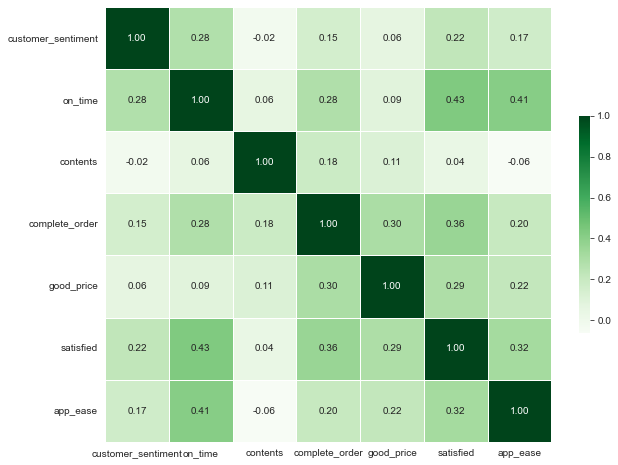

In [13]:
#plot correlation matrix heatmap
corr = df.corr()

sns.set_style("whitegrid")
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='Greens', fmt=".2f", 
            xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

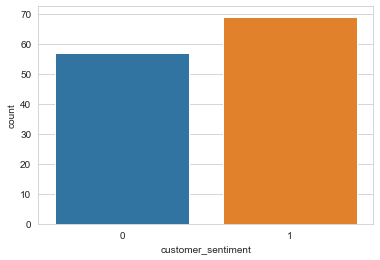

In [14]:
sns.countplot(df["customer_sentiment"],orient="V")
plt.show()

**the countplot shows that the column for the customer sentiment is almost equally distributed between happy and not happy customers**

In [15]:
df['customer_sentiment'].value_counts()

1    69
0    57
Name: customer_sentiment, dtype: int64

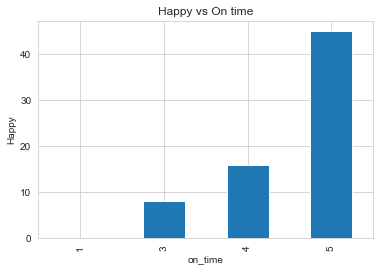

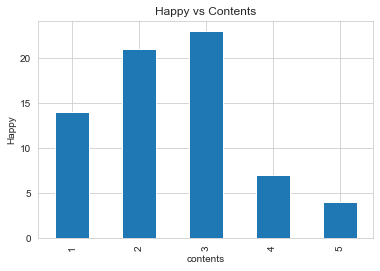

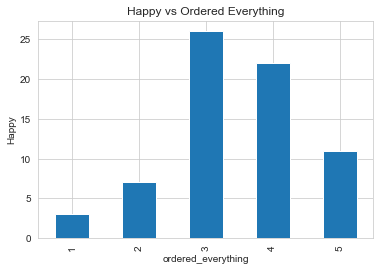

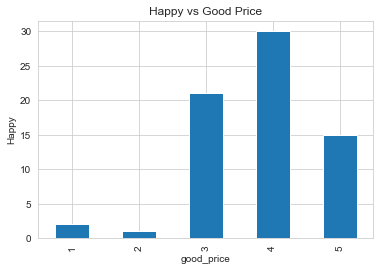

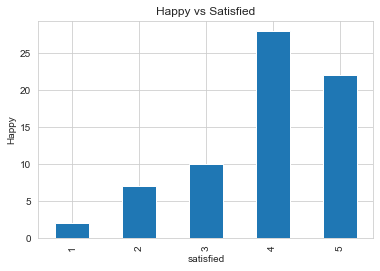

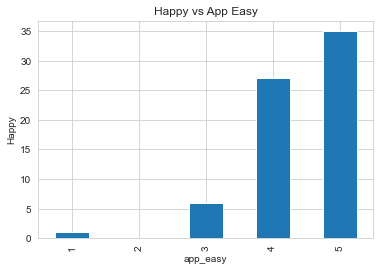

In [16]:
df.groupby('on_time')['customer_sentiment'].sum().plot(kind='bar')
plt.xlabel('on_time')
plt.ylabel('Happy')
plt.title('Happy vs On time')
plt.show()

df.groupby('contents')['customer_sentiment'].sum().plot(kind='bar')
plt.xlabel('contents')
plt.ylabel('Happy')
plt.title('Happy vs Contents')
plt.show()

df.groupby('complete_order')['customer_sentiment'].sum().plot(kind='bar')
plt.xlabel('ordered_everything')
plt.ylabel('Happy')
plt.title('Happy vs Ordered Everything')
plt.show()

df.groupby('good_price')['customer_sentiment'].sum().plot(kind='bar')
plt.xlabel('good_price')
plt.ylabel('Happy')
plt.title('Happy vs Good Price')
plt.show()

df.groupby('satisfied')['customer_sentiment'].sum().plot(kind='bar')
plt.xlabel('satisfied')
plt.ylabel('Happy')
plt.title('Happy vs Satisfied')
plt.show()

df.groupby('app_ease')['customer_sentiment'].sum().plot(kind='bar')
plt.xlabel('app_easy')
plt.ylabel('Happy')
plt.title('Happy vs App Easy')
plt.show()

**Preliminary Analysis:**

**On Time:** Seems to have the strongest correlation out of all the features.

**Contents as Expected:** Does **NOT** seem to have any strong relationship to happiness.

**Ordered Everything:** Also does **NOT** seem to have any meaningful relationship to happiness.

**Good Price:** Seems to have a loosely positive correlation to happiness, this is also shown through the correlation matrix.

**Satisfied With Courier:** Has a strong positive linear relationship to happiness.

**App Easy:** Positively correlated to happiness.

## Modeling

In [17]:
# define dataset features
features = ['on_time', 'contents', 'complete_order', 'good_price', 'satisfied', 'app_ease']

X = df.loc[:, features]
y = df.loc[:, ['customer_sentiment']]

#X = df[['on_time', 'contents', 'complete_order', 'good_price', 'satisfied', 'app_ease']]
#y = df['customer_sentiment']

**Split Data**

In [18]:
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

**Scale the Data with Standard Scaler**

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**XGBoostClassifier**

In [20]:
xgb_classifier = xgb.XGBClassifier()

xgb_classifier.fit(X_train_scaled, y_train)

xgb_pred = xgb_classifier.predict(X_test_scaled)

print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.42      0.42      0.42        12
           1       0.50      0.50      0.50        14

    accuracy                           0.46        26
   macro avg       0.46      0.46      0.46        26
weighted avg       0.46      0.46      0.46        26



Text(0.5, 1.0, 'Feature Importance')

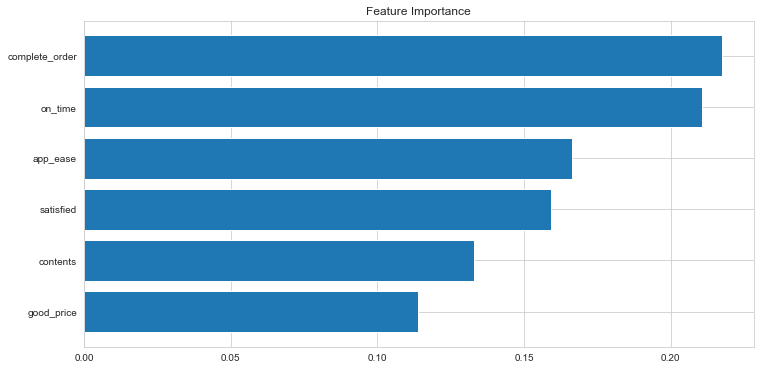

In [21]:
feature_importance = xgb_classifier.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

**Feature Importance Analysis:** 

According to this default parameter XGBoost Model, from the most to least important features is complete_order, on_time, app_ease, satisfied, contents, good_price. This will help in selecting features for the final model.

**Feature Selection:** 

Out of all the features in the dataset, most do not seem as if they would help predict happiness. For this first round I will remove all features except on_time, satisfied, and ordered_everything as on_time, and satisfied have the most correlation with happiness, and ordered_everything has the highest feature importance from the XGBoost model.

In [22]:
#choose reduced number of features
features = ['on_time','complete_order','satisfied'] 

X = df.loc[:, features]
y = df.loc[:, ['customer_sentiment']]

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Retry Fitting XGBoost on new smaller feature set:**

In [23]:
xgb_classifier.fit(X_train_scaled,y_train)

y_pred = xgb_classifier.predict(X_test_scaled)
y_train_pred = xgb_classifier.predict(X_train_scaled)
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.79
0.6153846153846154
              precision    recall  f1-score   support

           0       0.57      0.67      0.62        12
           1       0.67      0.57      0.62        14

    accuracy                           0.62        26
   macro avg       0.62      0.62      0.62        26
weighted avg       0.62      0.62      0.62        26



#### Try another combination of features to get the desired accuracy. 

In [25]:
#choose reduced number of features
features = ['on_time','satisfied','contents'] 

X = df.loc[:, features]
y = df.loc[:, ['customer_sentiment']]

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
xgb_classifier.fit(X_train_scaled,y_train)

y_pred = xgb_classifier.predict(X_test_scaled)
y_train_pred = xgb_classifier.predict(X_train_scaled)
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8
0.8461538461538461
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        12
           1       0.92      0.79      0.85        14

    accuracy                           0.85        26
   macro avg       0.85      0.85      0.85        26
weighted avg       0.86      0.85      0.85        26



**Final Model Analysis:**

This model with on_time, satisfied, and contents as features performed the best and meets the .73 minimum requirement on accuracy on both the test set, and training set. Also, the model performs better on the test set than the training set, with a .85 accuracy on the test set, while getting a .8 on the training set. This means that the model has NOT overfitted.

**Conclusion:** 

Not included in this notebook, is many tests with other models, feature sets, and hyperparameter tuning. I previously tested a Logistic Regression, Support Vector Machine and a Random Forest model, with XGBoost outperforming all of them.

Some model had promising results as the random forest model initially seemed like better, however it failed to improve with feature selection.

XGBoost model performed better after feature selection with the random forest model producing a .71 accuracy on test data, while the XGBoost model had a .85 accuracy on test data.

Overall, the best performing model was the XGBoost model given that it had a higher accuracy, precision, and recall than the Random Forest model. On all these metrics the XGBoost model performed the best.

**Recommendations:**

In order to best predict customer happiness, the company only needs to ask if the customer is:
1. Satisfied with the courier 
2. If the delivery was on time
3. If all the contents of the delivery were as expected

combination of all other questions do not lead to as good of predictions.

If the company wants to improve customer satisfaction, they should improve these aspects of the customer experience.

